In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#packages
import pickle
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.io.parsers import read_csv

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
#specify version of tensoflow!
%tensorflow_version 1.15.0
import tensorflow as tf
from tensorflow.python.framework import ops


%matplotlib inline
np.random.seed(1)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
import h5py
import numpy as np
import tensorflow as tf
import math

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y



In [ ]:
#load data

training_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/train.p'
validation_file='/content/drive/MyDrive/Colab Notebooks/Datasets/valid.p'
testing_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#sign_names = read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/sign_names.csv").values[:, 0]

#uncomment this if you want to train on the original data! but I have now augumented Data!
X_train_orig, Y_train_orig = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test_orig, Y_test_orig = test['features'], test['labels']

In [ ]:
# Flatten the training and test images
#X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize image vectors
#X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 43)
Y_test = convert_to_one_hot(Y_test_orig, 43)

#print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
#print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of test examples = 12630
Y_train shape: (43, 34799)
X_test shape: (3072, 12630)
Y_test shape: (43, 12630)


In [ ]:
#  create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "tf.float32"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "tf.float32"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(shape = [n_x, None], dtype = tf.float32, name = 'X')
    Y = tf.placeholder(shape = [n_y, None], dtype = tf.float32, name = 'Y')
    ### END CODE HERE ###
    
    return X, Y

In [ ]:
# initialize_parameters

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 3072]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [43, 12]
                        b3 : [43, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    #tf.random.set_seed(1)    
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [30,3072], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [30,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,30], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [43,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [43,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [ ]:
# forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                    # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                   # Z2 = np.dot(W2, A1) + b2
    A2 = tf.nn.relu(Z2)                                  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                   # Z3 = np.dot(W3, A2) + b3
    ### END CODE HERE ###
    
    return Z3

In [ ]:
#  compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [ ]:
#build the model!

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    #tf.random.set_seed(1)
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    num_examples = len(X_train)
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            # X_train, Y_train = shuffle(X_train, Y_train)

            # for offset in range(0, num_examples, minibatch_size):
            #     end = offset + minibatch_size
            #     batch_x, batch_y = X_train[offset:end], Y_train[offset:end]

            #     _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: batch_x, Y: batch_y})
                
            #     epoch_cost += minibatch_cost / minibatch_size

            for minibatch in minibatches:   

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

In [ ]:
##Load premade augmented data

augmented_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/augmentedData3000.npz'

loaded = np.load(augmented_file)
X_train_aug_orig = loaded['X_train_aug']
y_train_aug_orig = loaded['y_train_aug']

print("Augmented Dataset size X")
print(X_train_aug_orig.shape)
print("Augmented Dataset size y")
print(y_train_aug_orig.shape)

Augmented Dataset size X
(129000, 32, 32, 3)
Augmented Dataset size y
(129000,)


In [ ]:
# Flatten the training and test images
X_train_aug_orig_flatten = X_train_aug_orig.reshape(X_train_aug_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train_aug = X_train_aug_orig_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train_aug = convert_to_one_hot(y_train_aug_orig, 43)
Y_test = convert_to_one_hot(Y_test_orig, 43)

print ("number of training examples = " + str(X_train_aug.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train_aug.shape))
print ("Y_train shape: " + str(Y_train_aug.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 129000
number of test examples = 12630
X_train shape: (3072, 129000)
Y_train shape: (43, 129000)
X_test shape: (3072, 12630)
Y_test shape: (43, 12630)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 109.947006
Cost after epoch 100: 42.313779
Cost after epoch 200: 38.086606
Cost after epoch 300: 36.067920
Cost after epoch 400: 34.678854
Cost after epoch 500: 33.553555
Cost after epoch 600: 32.401875
Cost after epoch 700: 31.552409
Cost after epoch 800: 30.917457
Cost after epoch 900: 30.431762
Cost after epoch 1000: 29.959849
Cost after epoch 1100: 29.580272
Cost after epoch 1200: 29.221350
Cost after epoch 1300: 28.9

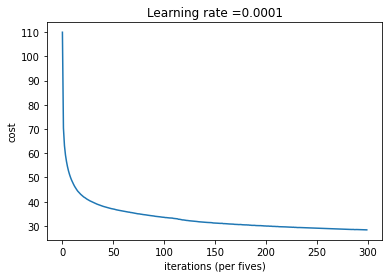

Parameters have been trained!
Train Accuracy: 0.7449845
Test Accuracy: 0.731829


In [ ]:
parameters = model(X_train_aug, Y_train_aug, X_test, Y_test)